In [1]:
from embeddings import load_embeddings
from sklearn.cluster import KMeans
import torch

#load embeddings-temporarily using small batch for testing-replace with dataset later
small_batch = torch.load('embeddings/all-MiniLM-L6-v2/00100000.pkl')

km = KMeans(n_clusters=4,random_state=0)
km.fit(small_batch)

KMeans(n_clusters=4, random_state=0)

In [2]:
#ensure clustering occurred for basic test
print(km.labels_)

[3 3 1 ... 0 1 3]


In [3]:
cluster_count = range(2, 6)

km_multiple = [KMeans(n_clusters=i) for i in cluster_count]
#jsquared errors for evaluating internal consistency in clusters
fits = [i.fit(small_batch).score(small_batch) for i in km_multiple]

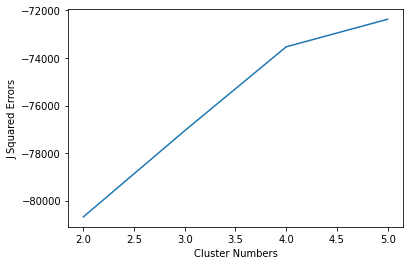

In [4]:
import matplotlib.pyplot as plt

plt.plot(cluster_count, fits)
plt.xlabel("Cluster Numbers")
plt.ylabel("J Squared Errors")
plt.show()

In [ ]:
import numpy as np

pred = km_multiple[4].fit(small_batch)
#We want to find the top feature vectors per cluster
#only consider unique "words"
labels = np.unique(pred)


In [3]:
import torch
import pandas as pd
import json
# from torch.utils.data import DataLoader, SequentialSampler
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from itertools import chain
from tqdm.auto import tqdm
from pathlib import Path

from dataset import TwitterDataset
from autoencoders import load_encoder

dset = TwitterDataset(
    'timestamp',
    'sentiment/vader/',
    # whole_text_path = 'whole_text',
    # token_path = 'tokens/text',
    embedding_path = 'embeddings/all-MiniLM-L6-v2/',
)

loading from timestamp:   0%|          | 0/221 [00:00<?, ?it/s]

loading embeddings..:   0%|          | 0/221 [00:00<?, ?it/s]

loaded dataset. took 108.44935349747539 ms


In [4]:
model = load_encoder('models/LinearAutoEncoder.pkl','linear')
for p in model.parameters():
    p.requires_grad = False

In [20]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
size = 1000000
model = model.cuda()

#find elbow using inertia and distortion
#use minibatch for optimal k computation to speed up calculations
cluster_count = range(2, 11)
batched_elbows = [0]*len(cluster_count)
sillhouettes = [0]*len(cluster_count)
km_multiple = [MiniBatchKMeans(n_clusters=i, max_iter=100) for i in cluster_count]

In [21]:
it_count = 0
for i in range(len(dset.embedding)):
  it_count+=1
  inp = dset.embedding[i*size: (i+1)*size].cuda()
  out = model.encoder(inp).cpu().numpy()
  if len(out) == 0:
    break
  fits = [i.fit(out) for i in km_multiple]
  inertias = [i.inertia_ for i in fits]
  s_scores = [silhouette_score(out, i.labels_) for i in fits]
  sillhouettes = [a+b for a,b in zip(s_scores, sillhouettes)]
  batched_elbows = [a+b for a, b in zip(fits, batched_elbows)]
  
  del out
  #jsquared errors for evaluating internal consistency in clusters

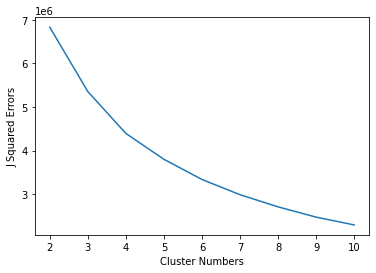

In [ ]:
import matplotlib.pyplot as plt

results = [x/it_count for x in batched_elbows]
plt.plot(cluster_count, results)
plt.xlabel("Cluster Numbers")
plt.ylabel("J Squared Errors")
plt.show()

In [ ]:
from kneed import KneeLocator
knee_loc = KneeLocator(range(2, 11), batched_elbows, curve="convex", direction="decreasing")
knee_loc.elbow

5

In [ ]:
from sklearn.cluster import DBSCAN

batched_dbelbows = [0]*len(cluster_count)
db_multiple = [DBSCAN(n_clusters=i, max_iter=100) for i in cluster_count]